***

Profesor: Gonzalo A. Ruz, PhD

Curso: Aprendizaje Automático

***

In [1]:
# Global imports and settings
# Global imports and settings
import keras
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
print("Using Keras",keras.__version__)
print("Using Tensorflow",tensorflow.__version__)
%matplotlib inline

Using Keras 2.10.0
Using Tensorflow 2.10.0


# Clase: Deep learning para datos secuenciales- Redes neuronales recurrentes




![](https://drive.google.com/uc?id=11NyB4FeBcuz5-xNh4sMY0KyuXQKDw0Rm)

Una red neuronal recurrente con un loop. Fuente: Deep Learning with Python, FRANÇOIS CHOLLET.

En pseudocódigo, este es la RNN:

In [ ]:
#Pseudocódigo RNN

#El estado en t
state_t = 0

#Itera sobre elementos de secuencia
for input_t in input_sequence:
    output_t = f(input_t, state_t) 
  #La salida anterior se convierte en el estado para la siguiente iteración.
    state_t = output_t



* Incluso puede botar la función `f`: la transformación de la entrada y el estado en una salida será parametrizada por dos matrices, `W` y `U`, y un vector de sesgo (bias). Es similar a la transformación operada por una capa densamente conectada en una red feedforward.

In [ ]:
# El mismo pseudocódigo de antes pero más detallado

state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b) # producto punto entre entrada y una matriz de peso + mismo estado con matriz de peso
    state_t = output_t


### Una capa recurrente en Keras

* El proceso descrito antes, corresponde efectivamente a una capa en Keras llamada `SimpleRNN`:

In [2]:
from tensorflow.keras.layers import SimpleRNN

* Hay una pequeña diferencia: `SimpleRNN` procesa lotes (batches) de secuencias, como todas las demás capas de Keras
* Esto significa que toma entradas de forma `(batch_size, timesteps, input_features)`

* Al igual que todas las capas recurrentes en Keras, `SimpleRNN` se puede ejecutar en dos modos diferentes: puede devolver las secuencias completas de salidas sucesivas para cada paso de tiempo (un tensor de forma 3D `(batch_size, timesteps, output_features)`) o solo la última salida para cada secuencia de entrada (un tensor de forma 2D `(batch_size, output_features)`).

* Estos dos modos están controlados por el argumento del constructor `return_sequences`. Veamos un ejemplo que usa `SimpleRNN` y devuelve solo la salida en el último paso de tiempo:

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32)) # embeddings es cantidad de palabras, dimensión 32
model.add(SimpleRNN(32))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


* El siguiente ejemplo devuelve la secuencia de estado completo:

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True)) #se utliza para apilar capas recurrentes
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


* A veces es útil apilar varias capas recurrentes una tras otra para aumentar el poder de representación de una red. 

* En dicha configuración, se debe obtener todas las capas intermedias para devolver secuencias completas:

In [6]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True)) #todas las capas recurrentes antes de la última, deben tener return_sequences
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  #La última capa solo devuelve la última salida
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


* Ahora, usemos ese modelo en el problema de clasificación de revisión de películas de IMDB. 

* Primero, vamos a preprocesar los datos.

In [7]:
#Preparando los datos IMDB

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  #Número de palabras a considerar como características
maxlen = 500  #Corta los textos después de esa cantidad de palabras 
              #(entre las palabras más comunes de max_features)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)


Loading data...
17464789/17464789 [==============================] - 1s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


* Vamos a entrenar una red recurrente simple usando una capa `Embedding` y una capa `SimpleRNN`. 

In [ ]:
#tarda 12min y medio aprox. en google colab
# Entrenamiento del modelo con embedding y capas simples de RNN

from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


* Ahora, vamos a mostrar la pérdida y accuracy de entrenamiento y validación.

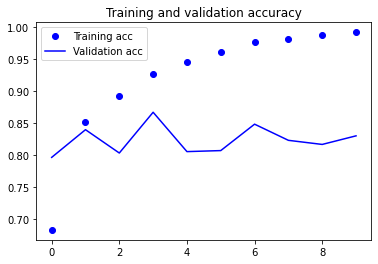

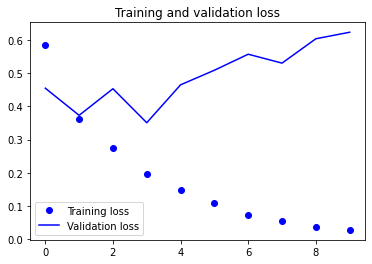

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* Como recordatorio, anteriormente, el primer enfoque ingenuo de este conjunto de datos nos llevó a un accuracy de prueba del 88%. 

* Lamentablemente, esta pequeña red recurrente no funciona bien en comparación con esta línea de base. 

* Parte del problema es que sus entradas solo consideran las primeras 500 palabras, en lugar de secuencias completas, por lo tanto, la RNN tiene acceso a menos información que el modelo de línea de base anterior. 

* El resto del problema es que `SimpleRNN` no es bueno para procesar secuencias largas, como el texto. 

* Otros tipos de capas recurrentes funcionan mucho mejor. Veamos algunas capas más avanzadas.

### Un ejemplo en concreto usando LSTM en Keras

* Ahora pasemos a algo más práctico: vamos a configurar un modelo con la capa `LSTM` y lo entrenaremos con los datos de IMDB. 

* La red es similar a la que vimos con `SimpleRNN`. 

* **Solo se necesita especificar la dimensionalidad de salida de la capa** `LSTM`; es mejor dejar cualquier otro argumento (hay muchos) en los valores predeterminados de Keras. Keras tiene buenos valores predeterminados.

In [ ]:
#Usando la capa LSTM de Keras (10 min aprox. CPU, 38 seg en GPU)

from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 8s 23ms/step - loss: 0.5081 - acc: 0.7645 - val_loss: 0.5277 - val_acc: 0.7410
Epoch 2/10
157/157 [==============================] - 3s 20ms/step - loss: 0.3020 - acc: 0.8819 - val_loss: 0.3375 - val_acc: 0.8596
Epoch 3/10
157/157 [==============================] - 3s 20ms/step - loss: 0.2396 - acc: 0.9085 - val_loss: 0.3073 - val_acc: 0.8694
Epoch 4/10
157/157 [==============================] - 4s 24ms/step - loss: 0.2028 - acc: 0.9245 - val_loss: 0.4220 - val_acc: 0.8498
Epoch 5/10
157/157 [==============================] - 3s 22ms/step - loss: 0.1742 - acc: 0.9356 - val_loss: 0.2925 - val_acc: 0.8920
Epoch 6/10
157/157 [==============================] - 3s 20ms/step - loss: 0.1574 - acc: 0.9445 - val_loss: 0.4618 - val_acc: 0.8154
Epoch 7/10
157/157 [==============================] - 3s 20ms/step - loss: 0.1452 - acc: 0.9493 - val_loss: 0.2949 - val_acc: 0.8828
Epoch 8/10
157/157 [==============================] - 3s 20ms/step - 

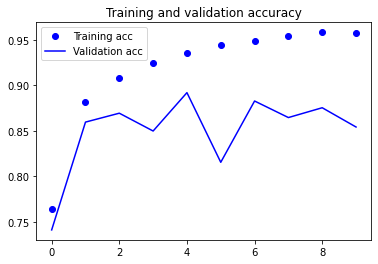

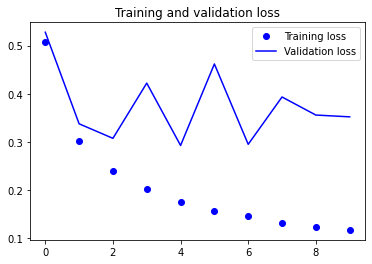

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* Esta vez, se logra un accuracy de validación de hasta el 88%. No está mal: ciertamente mucho mejor que la simple red RNN, en gran parte porque LSTM sufre mucho menos del problema de desvanecimiento del gradiente, y un poco mejor que el enfoque _fully connected_ de la clase anterior, a pesar de que está viendo menos datos de los que tenía en la clase anterior. Ahora nosotros estamos truncando secuencias después de 500 pasos, mientras que antes, estábamos considerando secuencias completas.

* Pero este resultado no es innovador para un enfoque computacionalmente intensivo. ¿Por qué LSTM no funciona mejor? Una razón es que no se hizo ningún esfuerzo para ajustar los hiperparámetros, como la dimensionalidad del embedding o la dimensionalidad de salida LSTM. 

* Otro puede ser la falta de regularización. 

* Pero, sinceramente, la razón principal es que analizar la estructura global a largo plazo de las revisiones (en qué es bueno LSTM) no es útil para un problema de análisis de sentimientos. 

* Tal problema básico se resuelve bien observando qué palabras aparecen en cada revisión y con qué frecuencia. 

* Eso es lo que miró el primer enfoque totalmente conectado. 

* Pero existen problemas de procesamiento del lenguaje natural mucho más difíciles, donde la fuerza de LSTM se hará evidente: en particular, la respuesta a preguntas y la traducción automática.

### GRU en Keras

* En lugar de la capa `LSTM` que vimos antes, vamos ha utilizar la capa `GRU`, desarrollada por [Chung et al. en 2014](https://arxiv.org/pdf/1412.3555.pdf). 

* Las capas Gated recurrent unit (GRU) funcionan utilizando el mismo principio que LSTM, pero son algo más sencillas y, por lo tanto, más baratas de ejecutar (aunque pueden no tener tanto poder de representación como LSTM). 

In [ ]:
#Usando la capa GRU de Keras (10 min aprox. en CPU, y 42 seg en GPU)
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


model = Sequential()
model.add(Embedding(max_features, 32))
model.add(layers.GRU(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 5s 25ms/step - loss: 0.5012 - acc: 0.7448 - val_loss: 0.3903 - val_acc: 0.8348
Epoch 2/10
157/157 [==============================] - 3s 20ms/step - loss: 0.3053 - acc: 0.8734 - val_loss: 0.2960 - val_acc: 0.8806
Epoch 3/10
157/157 [==============================] - 3s 20ms/step - loss: 0.2439 - acc: 0.9042 - val_loss: 0.3308 - val_acc: 0.8586
Epoch 4/10
157/157 [==============================] - 3s 21ms/step - loss: 0.2117 - acc: 0.9171 - val_loss: 0.3384 - val_acc: 0.8506
Epoch 5/10
157/157 [==============================] - 4s 24ms/step - loss: 0.1905 - acc: 0.9309 - val_loss: 0.3097 - val_acc: 0.8718
Epoch 6/10
157/157 [==============================] - 4s 22ms/step - loss: 0.1657 - acc: 0.9384 - val_loss: 0.3020 - val_acc: 0.8782
Epoch 7/10
157/157 [==============================] - 3s 20ms/step - loss: 0.1498 - acc: 0.9449 - val_loss: 0.3458 - val_acc: 0.8720
Epoch 8/10
157/157 [==============================] - 3s 20ms/step - 

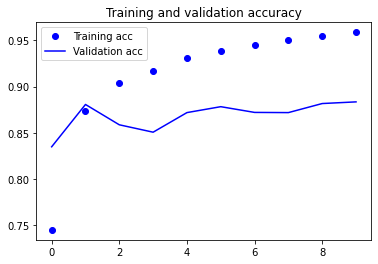

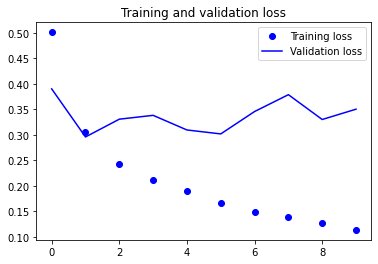

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Usando dropout recurrente para combatir el sobreajuste

* Ya estamos familiarizado con una técnica clásica para combatir este fenómeno: dropout, que elimina al azar las unidades de entrada de una capa para romper las correlaciones de casualidad en los datos de entrenamiento a los que está expuesta la capa. 

* Pero cómo aplicar correctamente dropout en redes recurrentes no es una pregunta trivial. 

* Hace tiempo que se sabe que aplicar dropout antes de una capa recurrente dificulta el aprendizaje en lugar de ayudar con la regularización. 

* En 2015, [Yarin Gal](http://mlg.eng.cam.ac.uk/yarin/blog_2248.html), como parte de su tesis doctoral sobre aprendizaje profundo Bayesiano, determinó la forma correcta de usar dropout con una red recurrente: la misma máscara dropout (el mismo patrón de unidades abandonadas) debe aplicarse en todo momento - paso, en lugar de una máscara dropout que varía aleatoriamente de un paso a otro. 

* Además, para regularizar las representaciones formadas por las puertas recurrentes de capas como `GRU` y `LSTM`, se debe aplicar una máscara dropout temporal constante a las activaciones recurrentes internas de la capa (una máscara dropout recurrente). 

* El uso de la misma máscara dropout en cada paso de tiempo permite a la red propagar adecuadamente su error de aprendizaje a través del tiempo; Una máscara dropout temporal aleatoria interrumpiría esta señal de error y sería perjudicial para el proceso de aprendizaje.

* Cada capa recurrente en Keras tiene dos argumentos relacionados con dropout: `dropout`, un número que especifica la tasa de dropout para las unidades de entrada de la capa y `recurrent_dropout`, que especifica la tasa de dropout de las unidades recurrentes. 

* Agreguemos el dropout y el dropout recurrente a `GRU` y veamos cómo hacerlo afecta el sobreajuste. 

* Debido a que las redes que se regularizan con dropout siempre tardan más en converger por completo, vamos a entrenar la red durante el doble de épocas.

In [ ]:
#Usando la capa GRU con dropout (40 min aprox., sin cuDNN 1.5 hrs)
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


model = Sequential()
model.add(Embedding(max_features, 32))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/20
157/157 [==============================] - 285s 2s/step - loss: 0.5508 - acc: 0.7139 - val_loss: 0.4400 - val_acc: 0.7924
Epoch 2/20
157/157 [==============================] - 283s 2s/step - loss: 0.3413 - acc: 0.8616 - val_loss: 0.3982 - val_acc: 0.8590
Epoch 3/20
157/157 [==============================] - 284s 2s/step - loss: 0.2882 - acc: 0.8860 - val_loss: 0.3052 - val_acc: 0.8700
Epoch 4/20
157/157 [==============================] - 282s 2s/step - loss: 0.2435 - acc: 0.9080 - val_loss: 0.3404 - val_acc: 0.8724
Epoch 5/20
157/157 [==============================] - 282s 2s/step - loss: 0.2219 - acc: 0.9182 - val_loss: 0.3315 - val_acc: 0.8654
Epoch 6/20
157/157 [==============================] - 279s 2s/step - loss: 0.1907 - acc: 0.9291 - val_loss: 0.2926 - val_acc: 0.8870
Epoch 7/20
157/157 [==============================] - 281s 2s/step - loss: 0.1701 - acc: 0.9372 - val_loss: 0.3092 - val_acc: 0.8886
Epoch 8/20
157/157 [==============================] - 281s 2s/step - 

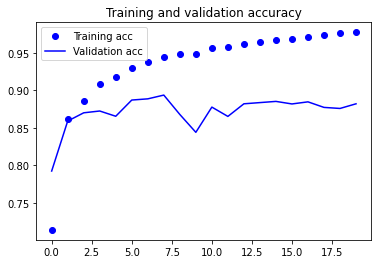

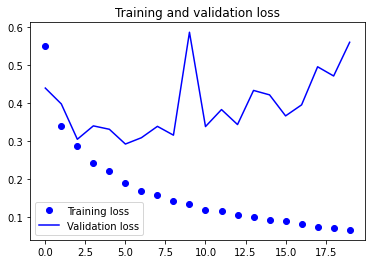

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Apilando capas recurrentes

* Mientras no se esté demasiado sobreajustado, es probable que la red esté bajo su capacidad.

* El aumento de la capacidad de la red generalmente se realiza aumentando el número de unidades en las capas o agregando más capas. 

* El apilamiento de capas recurrentes es una forma clásica de construir redes recurrentes más potentes: por ejemplo, lo que actualmente impulsa el algoritmo de Google Translate es una pila de ocho capas `LSTM` grandes, eso es enorme.

* Para apilar capas recurrentes una encima de otra en Keras, todas las capas intermedias deben devolver su secuencia completa de salidas (un tensor 3D) en lugar de su salida en el último paso de tiempo. 

* Esto se hace especificando `return_sequences = TRUE`.

* Veamos usando dos capas GRU para luego finalizar con una capa densa.

In [ ]:
#stacked GRU usando regularización dropout (38 min aprox., sin cuDNN 1.5 hrs)
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense


model = Sequential()
model.add(Embedding(max_features, 32))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
model.add(layers.GRU(32, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


Epoch 1/10
157/157 [==============================] - 567s 4s/step - loss: 0.5500 - acc: 0.7129 - val_loss: 0.3765 - val_acc: 0.8370
Epoch 2/10
157/157 [==============================] - 563s 4s/step - loss: 0.3487 - acc: 0.8585 - val_loss: 0.4237 - val_acc: 0.8224
Epoch 3/10
157/157 [==============================] - 552s 4s/step - loss: 0.2812 - acc: 0.8923 - val_loss: 0.3744 - val_acc: 0.8706
Epoch 4/10
157/157 [==============================] - 555s 4s/step - loss: 0.2341 - acc: 0.9125 - val_loss: 0.6770 - val_acc: 0.8266
Epoch 5/10
157/157 [==============================] - 550s 4s/step - loss: 0.2091 - acc: 0.9215 - val_loss: 0.3058 - val_acc: 0.8794
Epoch 6/10
157/157 [==============================] - 553s 4s/step - loss: 0.1825 - acc: 0.9337 - val_loss: 0.3447 - val_acc: 0.8702
Epoch 7/10
157/157 [==============================] - 551s 4s/step - loss: 0.1636 - acc: 0.9406 - val_loss: 0.5938 - val_acc: 0.8532
Epoch 8/10
157/157 [==============================] - 552s 4s/step - 

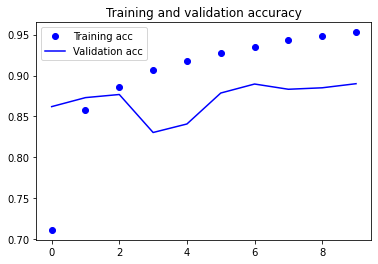

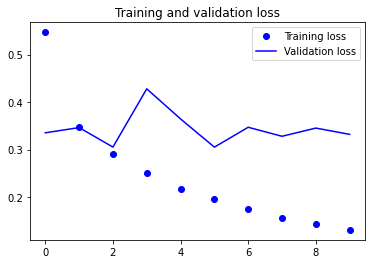

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Uso de RNN bidireccionales

* Ahora veremos una técnica llama RNN bidireccionales. 

* Una RNN bidireccional es una variante común de RNN que puede ofrecer un mayor rendimiento que un RNN normal en ciertas tareas. 

* Se usa con frecuencia en el procesamiento del lenguaje natural.

* Las RNN dependen notablemente del orden o del tiempo: procesan los pasos de tiempo de sus secuencias de entrada en orden, y la idea de mezclar o invertir los pasos de tiempo puede cambiar completamente las representaciones que la RNN extrae de la secuencia. 

* Una RNN bidireccional explota la sensibilidad del orden de las RNN: consiste en usar dos RNN regulares, como capas `GRU` y `LSTM` que ya conocemos, cada una de los cuales procesa la secuencia de entrada en una dirección (cronológica y anticronológicamente), y luego fusiona sus representaciones. 

* Al procesar una secuencia en ambos sentidos, una RNN bidireccional puede capturar patrones que un RNN unidireccional puede pasar por alto.

* Sorprendentemente, el hecho de que las capas de una RNN que hemos usado en los ejemplos previos usan secuencias procesadas en orden cronológico (los pasos de tiempo más antiguos primero) puede haber sido una decisión arbitraria. 

* Al menos, es una decisión que no hemos intentado cuestionar hasta ahora. 

* ¿Podrían las RNN haber funcionado lo suficientemente bien si procesaran secuencias de entrada en orden anticronológico, por ejemplo (primero los pasos más nuevos)? 

* Probemos este enfoque en el ejemplo LSTM IMDB

In [ ]:

#tarda 2 min aporx. en google colab con GPU
#Entrenamiento y evaluación de un LSTM usando secuencias invertidas
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#Número de palabras a considerar como características
max_features = 10000
#Corta los textos después de este número de palabras 
#(entre las palabras más comunes de max_features)
maxlen = 500

# Cargar los datos
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

#Invierta las secuencias
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Rellena (Pad) las secuencias
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


17473536/17464789 [==============================] - 0s 0us/step
Epoch 1/10
157/157 [==============================] - 12s 26ms/step - loss: 0.4971 - acc: 0.7593 - val_loss: 0.5589 - val_acc: 0.7688
Epoch 2/10
157/157 [==============================] - 4s 23ms/step - loss: 0.3125 - acc: 0.8792 - val_loss: 0.3421 - val_acc: 0.8628
Epoch 3/10
157/157 [==============================] - 4s 24ms/step - loss: 0.2496 - acc: 0.9073 - val_loss: 0.4358 - val_acc: 0.8498
Epoch 4/10
157/157 [==============================] - 4s 23ms/step - loss: 0.2176 - acc: 0.9234 - val_loss: 0.3516 - val_acc: 0.8696
Epoch 5/10
157/157 [==============================] - 4s 23ms/step - loss: 0.1940 - acc: 0.9326 - val_loss: 0.4473 - val_acc: 0.8626
Epoch 6/10
157/157 [==============================] - 4s 23ms/step - loss: 0.1698 - acc: 0.9411 - val_loss: 0.3784 - val_acc: 0.8568
Epoch 7/10
157/157 [==============================] - 4s 23ms/step - loss: 0.1536 - acc: 0.9468 - val_loss: 0.3743 - val_acc: 0.8726
Epo

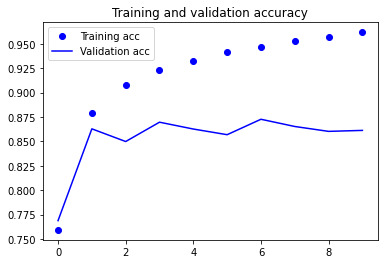

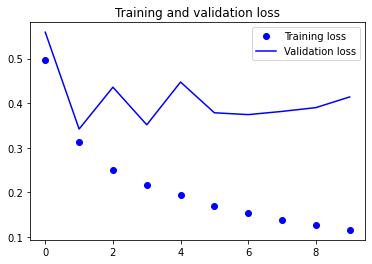

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* Se obtiene un rendimiento casi idéntico al del LSTM de orden cronológico. 

* Sorprendentemente, en un conjunto de datos de texto de este tipo, el procesamiento de orden inverso funciona tan bien como el procesamiento cronológico, lo que confirma la hipótesis de que, aunque el orden de las palabras es importante para comprender el lenguaje, el orden que se utiliza no es crucial.

* Una RNN bidireccional aprovecha esta idea para mejorar el rendimiento de las RNN de orden cronológico. 

* Mira la secuencia de entrada en ambos sentidos (tal como la figura de abajo), obteniendo representaciones potencialmente más ricas y capturando patrones que pueden haber sido pasados por alto por la versión de orden solo cronológico.

![](https://drive.google.com/uc?id=1E-CaGCZsFeouA99_sz-O6sNR_-e2yQ8L)
Cómo funciona una capa RNN bidireccional. Fuente: Deep Learning with Python, FRANÇOIS CHOLLET.

* Para instanciar una RNN bidireccional en Keras, se utiliza la capa `Bidirectional`, que toma una instancia de capa recurrente como argumento. 

* La capa `Bidirectional` crea una segunda instancia separada de esta capa recurrente y usa una instancia para procesar las secuencias de entrada en orden cronológico y la otra instancia para procesar las secuencias de entrada en orden inverso. 

* Probémoslo en la tarea de análisis de sentimientos IMDB.

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
#tarda 1 min aprox. en google colab con GPU
#Entrenamiento y evaluación de un LSTM bidireccional.

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10
157/157 [==============================] - 13s 64ms/step - loss: 0.5259 - acc: 0.7342 - val_loss: 1.3922 - val_acc: 0.5184
Epoch 2/10
157/157 [==============================] - 6s 37ms/step - loss: 0.3303 - acc: 0.8740 - val_loss: 0.3465 - val_acc: 0.8576
Epoch 3/10
157/157 [==============================] - 6s 37ms/step - loss: 0.2667 - acc: 0.9043 - val_loss: 0.3855 - val_acc: 0.8418
Epoch 4/10
157/157 [==============================] - 6s 37ms/step - loss: 0.2182 - acc: 0.9209 - val_loss: 0.3165 - val_acc: 0.8856
Epoch 5/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1988 - acc: 0.9298 - val_loss: 0.3459 - val_acc: 0.8688
Epoch 6/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1759 - acc: 0.9392 - val_loss: 0.3830 - val_acc: 0.8386
Epoch 7/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1620 - acc: 0.9447 - val_loss: 0.4971 - val_acc: 0.8420
Epoch 8/10
157/157 [==============================] - 6s 37ms/step -

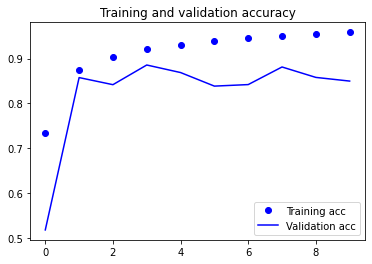

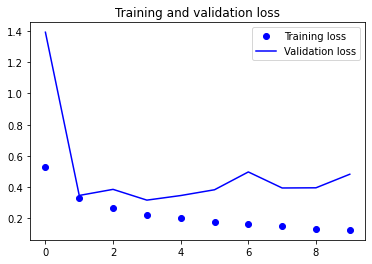

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()




* Posiblemente con cierta regularización, el enfoque bidireccional tendrá un gran desempeño en esta tarea.

## Procesamiento de secuencias con convnets

* Anteriormente, aprendimos sobre las redes neuronales convolucionales (convnets) y cómo funcionan particularmente bien en problemas de visión por computadora, debido a su capacidad para operar de manera convolucional, extrayendo características de parches de entrada locales y permitiendo modularidad de representación y eficiencia de datos. 

* Las mismas propiedades que hacen que las convnets se destaquen en la visión por computadora también las hacen muy relevantes para el procesamiento de secuencias. 

* El tiempo puede tratarse como una dimensión espacial, como la altura o el ancho de una imagen 2D.

* Tales convnets 1D pueden ser competitivas con las RNN en ciertos problemas de procesamiento de secuencias, generalmente a un costo computacional considerablemente más barato. 

* Recientemente, las convnets 1D, típicamente utilizadas con kernels dilatados o _dilated kernels_, se han utilizado con gran éxito para la generación de audio y la traducción automática. 

* Además de estos éxitos específicos, se sabe desde hace tiempo que los pequeños convnets 1D pueden ofrecer una alternativa rápida a las RNN para tareas simples como la clasificación de texto y el pronóstico de series de tiempo.



### Entendiendo la convolución 1D para datos de secuencia.

* Las capas de convolución introducidas anteriormente eran convoluciones 2D, extrayendo parches 2D de tensores de imagen y aplicando una transformación idéntica a cada parche. 

* Del mismo modo, se puede usar convoluciones 1D, extrayendo parches 1D locales (subsecuencias) de las secuencias, tal como en la siguiente figura.

![](https://drive.google.com/uc?id=1eND5Y_DxTCmMJ8E_Ie-D4Jzf9mhVqrdj)

Cómo funciona la convolución 1D: cada paso de tiempo de salida se obtiene de un parche temporal en la secuencia de entrada. Fuente: Deep Learning with Python, FRANÇOIS CHOLLET.

* Dichas capas de convolución 1D pueden reconocer patrones locales en una secuencia. 

* Debido a que se realiza la misma transformación de entrada en cada parche, un patrón aprendido en una determinada posición de una oración puede reconocerse más tarde en una posición diferente, lo que hace que las convnets 1D presenten invariancia traslacional (para traslaciones temporales). 

* Por ejemplo, una secuencia de caracteres de procesamiento de caracteres 1D usando ventanas de convolución de tamaño 5 debería poder aprender palabras o fragmentos de palabras de longitud 5 o menos, y debería ser capaz de reconocer estas palabras en cualquier contexto en una secuencia de entrada. 

* Una convnet 1D de nivel de caracteres es capaz de aprender sobre la morfología de las palabras.

### Pooling 1D para datos de secuencia

* Ya estamos familiarizados con las operaciones de agrupación (pooling) 2D, como la _average pooling_ 2D y la _max pooling_, que se utilizan en las convnets para reducir la dimensionalidad (submuestreo) espacial de los tensores de imagen. 

* La operación de pooling 2D tiene un equivalente 1D: extraer parches 1D (subsecuencias) de una entrada y generar el valor máximo (max pooling) o el valor promedio (average pooling). 

* Al igual que con las convnets 2D, esto se usa para reducir la longitud de las entradas 1D (submuestreo).

### Implementando una convnet 1D

* En Keras, se utiliza una convnet 1D a través de la capa `Conv1D`, que tiene una interfaz similar a `Conv2D`. 

* Toma como entrada los tensores 3D con forma `(samples, time, features)` y devuelve tensores 3D de forma similar. 

* La ventana de convolución es una ventana 1D en el eje temporal: eje (axis) 1 en el tensor de entrada.

* Vamos a crear una simple convnet 1D de dos capas y la aplicaremos a la tarea de clasificación de sentimientos de IMDB. 

* Como recordatorio, este es el código para obtener y preprocesar los datos.

In [ ]:
#Preparando los datos IMDB
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  #Número de palabras a considerar como características
max_len = 500  #Corta los textos después de este número de palabras 
               #(entre las palabras más comunes de max_features)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


* Las convnets 1D están estructuradas de la misma manera que sus contrapartes 2D, que usamos previamente: consisten en una pila de `Conv1D` y `MaxPooling1D`, que termina en una capa de agrupación global (pooling) o `Flatten`, que convierte las salidas 3D en salidas 2D, permitiendo agregar una o más capas densas al modelo para su clasificación o regresión.

* Sin embargo, una diferencia es el hecho de que puede permitirse el lujo de usar ventanas de convolución más grandes con convnets 1D. 

* Con una capa de convolución 2D, una ventana de convolución 3 × 3 contiene 3 × 3 = 9 vectores de características; pero con una capa de convolución 1D, una ventana de convolución de tamaño 3 contiene solo 3 vectores de características. Por lo tanto, puede permitirse fácilmente ventanas de convolución 1D de tamaño 7 o 9.

* Este es el ejemplo de una convnet 1D para el conjunto de datos IMDB.

In [ ]:
#tarda 25 seg aprox. en google colab con GPU
#Entrenamiento y evaluación de una simple convnet 1D en los datos de IMDB

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                

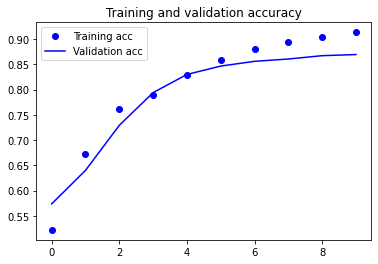

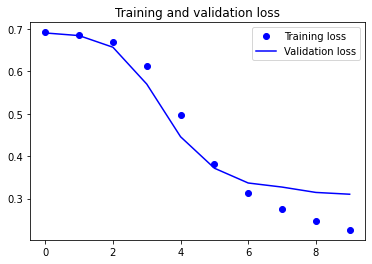

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* El gráfico muestra los resultados de entrenamiento y validación. 

* El accuracy de validación es algo menor que la del LSTM, pero el tiempo de ejecución es más rápido tanto en una CPU como en una GPU.

* En este punto, se puede volver a entrenar este modelo para la cantidad correcta de épocas (ocho) y ejecutarlo en el conjunto de prueba. 

* Esta es una demostración convincente de que una convnet 1D puede ofrecer una alternativa rápida y económica a una red recurrente en una tarea de clasificación de sentimientos a nivel de palabra.

### Combinando CNNs y RNNs para procesar secuencias largas



* Una estrategia para combinar la velocidad y la ligereza de las convnets con la sensibilidad del orden de las RNN es utilizar una convnet 1D como un paso de preprocesamiento antes de una RNN, tal como en la siguiente figura.

![](https://drive.google.com/uc?id=1KGPD0KrsZyJ9IdIewoTT_NAfJGOLM5_v)

Combinando una convnet 1D y una RNN para procesar secuencias largas. Fuente: Deep Learning with Python, FRANÇOIS CHOLLET.

* Esto es especialmente beneficioso cuando se trata de secuencias que son tan largas que no pueden procesarse de manera realista con una RNN, como secuencias con miles de pasos. 

* La convnet convertirá la secuencia de entrada larga en secuencias mucho más cortas (muestras reducidas) de características de nivel superior. 

* Esta secuencia de características extraídas se convierte en la entrada a la parte del RNN de la red.

*  Este es el modelo, comenzando con dos capas `Conv1D` y siguiendo con una capa `GRU`.

In [ ]:
#tarda 10 min aprox. en google colab con GPU (sin cuDNN)
#Modelo que combina una base convolucional 1D y una capa GRU

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 494, 32)           28704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                      

* Acá los resultados

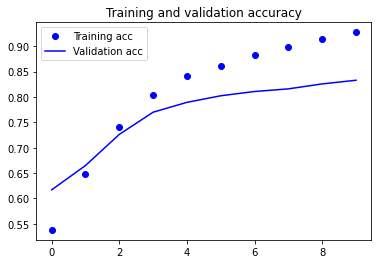

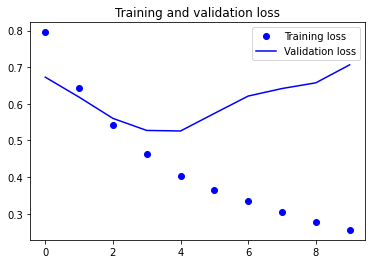

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* A modo de resumen:

    + Si el orden global es importante en sus datos de secuencia, entonces es preferible usar una red recurrente para procesarlos. Este suele ser el caso de la serie temporal, donde el pasado reciente es más informativo que el pasado lejano.
    
    + Si el orden global __no__ es fundamentalmente significativo, entonces las convnets 1D funcionarán al menos igual de bien y son más baratas. Este suele ser el caso de los datos de texto, donde una palabra clave que se encuentra al comienzo de una oración es tan significativa como una palabra clave que se encuentra al final.